In [2]:
import pysm
import numpy as np
import healpy as hp
from pysm.nominal import models
from pysm.common import convert_units
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
nu = np.array([30., 44., 70., 95., 150., 217., 353.]) 
coefficients = convert_units("uK_RJ", "uK_CMB", nu)
Nf = len(nu)

In [4]:
nside = 1024

In [5]:
def convert_unit(map):
    for i in range(0,Nf):
        map[i] = map[i]*coefficients[i]
    return map

In [6]:
c1_config = models("c1", nside)       
s1_config = models("s1", nside)
d1_config = models("d1", nside)
f1_config = models("f1", nside)
a1_config = models("a1", nside)
sky_config = {
    'synchrotron' : s1_config,
    'dust' : d1_config,
    'freefree' : f1_config,
    'cmb' : c1_config,
    'ame' : a1_config
}
sky = pysm.Sky(sky_config) 

#dust = sky.dust(nu);synchrotron = sky.synchrotron(nu);freefree = sky.freefree(nu)
#cmb = sky.cmb(nu); ame = sky.ame(nu)
#np.save('../simulation/Nside = 1024/dust_map.npy',convert_unit(dust)); np.save('../simulation/Nside = 1024/synchro_map.npy',convert_unit(synchrotron));
#np.save('../simulation/Nside = 1024/9_fre/cmb_map.npy',convert_unit(cmb)); #np.save('../simulation/Nside = 1024/freefree_map.npy',convert_unit(freefree));
#np.save('../simulation/Nside = 1024/ame_map.npy',convert_unit(ame))

total = sky.signal()(nu)
total_map = convert_unit(total)

In [7]:
cmb_map = coefficients[0]*sky.cmb(30)

In [43]:
cmb_cls = hp.anafast(cmb_map[0], lmax = 2000)

In [8]:
total_I = np.copy(total_map[0][0])
for i in range(Nf-1):
    total_I = np.row_stack((total_I, total_map[i+1][0]))

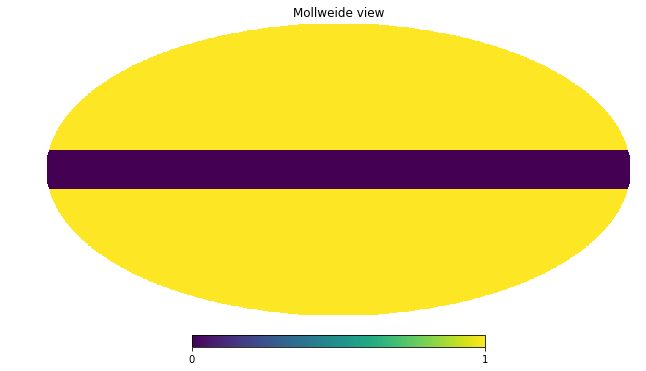

In [175]:
hp.mollview(my_mask)

In [244]:
cov = np.zeros((Nf, Nf))
index = np.arange(12*nside**2)
index_mask = index[my_mask]
for i in range(Nf):
#     mean_i = np.mean(total_I[i])
    for j in range(Nf):
#         mean_j = np.mean(total_I[j])
#         for k in range(12*nside**2):
#             cov[i,j] += (total_I[i][k] - mean_i)*(total_I[j][k] - mean_j)
#         cov[i, j] = np.dot(total_I[i] - np.mean(total_I[i]), total_I[j] - np.mean(total_I[j]))/12.0/nside**2
        cov[i, j] = np.dot(total_I[i][index_mask] - np.mean(total_I[i][index_mask]), total_I[j][index_mask] - np.mean(total_I[j][index_mask]))/len(index_mask)
# cov = cov/12.0/nside**2

In [153]:
f_sky = len(index[my_mask])*1.0/len(my_mask)

In [155]:
len(total_I[i][index_mask])

10399744

In [194]:
ev, evc = np.linalg.eig(cov)

In [245]:
cov #mask_inside

array([[  85352.03733924,   43094.41011002,   24676.25906184,
          21750.87867192,   26156.43539877,   47644.02604013,
         284119.76802847],
       [  43094.41011002,   25325.20961027,   17443.62243519,
          16109.19022053,   17714.29355916,   26124.43734708,
         119292.26760245],
       [  24676.25906184,   17443.62243519,   14271.36899438,
          13763.15674858,   14548.35124271,   18358.94170676,
          60304.21576303],
       [  21750.87867192,   16109.19022053,   13763.15674858,
          13495.23652727,   14495.27965466,   18539.11887516,
          62304.61409212],
       [  26156.43539877,   17714.29355916,   14548.35124271,
          14495.27965466,   17033.99990429,   25957.54116583,
         121000.20976316],
       [  47644.02604013,   26124.43734708,   18358.94170676,
          18539.11887516,   25957.54116583,   51316.48125806,
         320483.14340605],
       [ 284119.76802847,  119292.26760245,   60304.21576303,
          62304.61409212,  12100

In [179]:
ev # mask_inside

array([1.07425249e+08, 2.87759131e+06, 3.90722850e+04, 2.39000739e+03,
       2.67115487e+02, 1.35022332e+01, 3.77845008e-02])

In [123]:
len(index[my_mask]) 

10399744

In [246]:
cov_inv = np.linalg.pinv(cov)

In [247]:
w = np.zeros(Nf)
for i in range(Nf):
    w[i] = np.sum(cov_inv[i,:])/np.sum(cov_inv)

In [248]:
w

array([-0.1065273 ,  0.69201666, -4.97974461,  8.42330866, -4.4797351 ,
        1.53929861, -0.08861692])

In [251]:
cmb_ILC = np.dot(w, total_I)

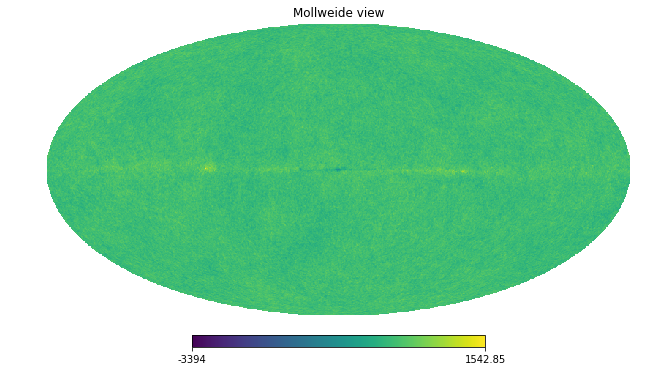

In [254]:
hp.mollview(cmb_ILC)

In [221]:
index[my_mask == False]

array([5199872, 5199873, 5199874, ..., 7383037, 7383038, 7383039])

In [255]:
cmb_ILC_mask = hp.ma(cmb_ILC)
cmb_ILC_mask.mask = my_mask#np.logical_not(my_mask)
cl_ILC_pix_mask = hp.anafast(cmb_ILC_mask, lmax = 2000)

In [256]:
cmb_mask = hp.ma(cmb_map[0])
cmb_mask.mask = my_mask #np.logical_not(my_mask)
cmb_mask_cls = hp.anafast(cmb_mask, lmax = 2000)

In [265]:
total_mask = hp.ma(total_I[0])
total_mask.mask = np.logical_not(my_mask)

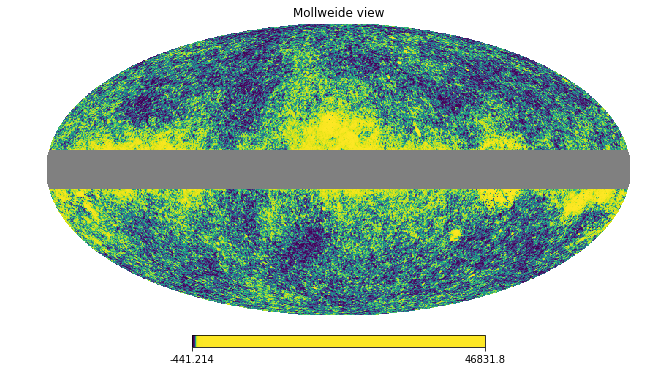

In [266]:
hp.mollview(total_mask, norm = 'hist')
plt.savefig('total_mask_inside_region.png', format = 'png')

In [212]:
cl_ILC_pix = hp.anafast(cmb_ILC, lmax = 2000)

In [213]:
L = 2000; Q = int(L/10.0); Ell = np.ones(Q)
def bin_l(cl):
    if len(cl.shape) > 2 :
        bin_averages = np.zeros((Q, cl.shape[1], cl.shape[1]))
    else:
        bin_averages = np.zeros(Q)
#     for l in range(L):
#         cl[l] = l*(l+1)/2/np.pi*(cl[l])    
    for q in range(Q):
        bin_averages[q] = (sum(cl[q*L//Q:((q+1)*L//Q)]/(L//Q)))
    return bin_averages

for i in range(0,int(Q)):
    Ell[i] = (2*i+1)*L//Q/2 

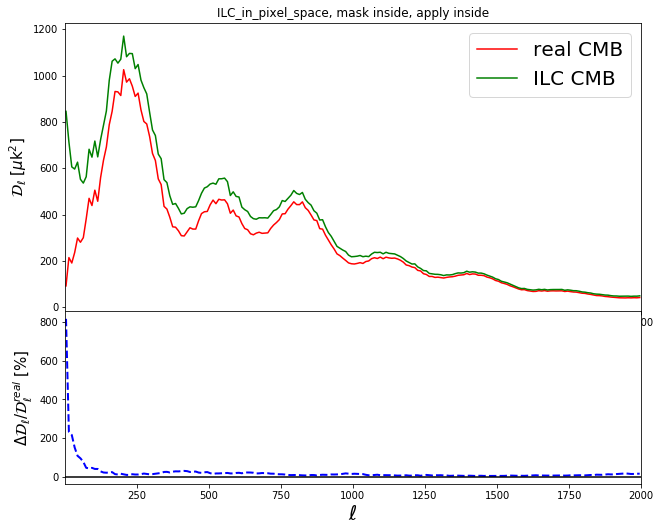

In [259]:
fig1 = plt.figure(1, figsize=(10,8))
# Ell = np.arange(len(cl_ILC_pix)); 
s, e = 2, 2000
plt.axis('off')

frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height
plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_mask_cls), 'r-',label = 'real CMB')
plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cl_ILC_pix_mask), 'g-', label = 'ILC CMB')
plt.xlim(s, e)
plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
plt.title('ILC_in_pixel_space, mask inside, apply inside')# the outside-galactic-plane region
plt.legend(fontsize = 20)

frame2=fig1.add_axes((.1,.1,.8,.3))
plt.plot(Ell, (bin_l(cl_ILC_pix_mask - cmb_mask_cls))/bin_l(cmb_mask_cls)*100, 'b--', lw = 2)
plt.axhline(0,color = 'k')
plt.ylabel(r'$\Delta \mathcal{D}_\ell$/$\mathcal{D}^{real}_{\ell} $ [%]', fontsize = 15);plt.xlabel(r'$\ell$', fontsize = 20)
# plt.ylim(-0.25, 1)
plt.xlim(s, e)

plt.savefig('ILC_pix_mask_inside_apply_inside.png', format = 'png')

# ILC in harmonic space

In [14]:
def Power_spectrum(maps,R, lmax):
    global cl
    ''' revised for upper-triangle of the matrix '''
    n_f = len(maps)
#     print(n_f)
    cl = np.ones((n_f*n_f, lmax +1)); Cl = np.zeros((lmax+1, n_f, n_f))
    k = 0
    for i in range(n_f):
        for j in range(n_f):
            
            if i >= j :
                cross_ps = hp.anafast(maps[i], maps[j], lmax = lmax, gal_cut=R)
            else:
                cross_ps = np.zeros(lmax+1) ## TT, EE, BB
            cl[k] = cross_ps  ## calculate the B_mode power spectrum 
            k += 1
#     print(cl.shape)
    for l in range(lmax+1):
        Cl[l, 0:n_f , 0:n_f] = cl[:,l].reshape(n_f, n_f)
        Cl[l] += Cl[l].T - np.diag(Cl[l].diagonal()) 
    return Cl

In [15]:
L = 2000; Q = int(L/10.0); Ell = np.ones(Q)
def bin_l(cl):
    if len(cl.shape) > 2 :
        bin_averages = np.zeros((Q, cl.shape[1], cl.shape[1]))
    else:
        bin_averages = np.zeros(Q)
#     for l in range(L):
#         cl[l] = l*(l+1)/2/np.pi*(cl[l])    
    for q in range(Q):
        bin_averages[q] = (sum(cl[q*L//Q:((q+1)*L//Q)]/(L//Q)))
    return bin_averages

for i in range(0,int(Q)):
    Ell[i] = (2*i+1)*L//Q/2 

In [16]:
total_ps= Power_spectrum(total_I, 0, 2000)

In [18]:
cls = bin_l(cmb_cls)

In [19]:

e = np.matrix(np.ones(Nf))
total_bin = bin_l(total_ps)
# total_bin = total_ps
cl_ilc = np.zeros(Q)
#calculate the weight
W = np.matrix(np.zeros((Q, Nf)))
for l in range(Q):
    norm = e*np.linalg.pinv((total_bin[l]))*e.T
    W[l,:] = e*np.linalg.pinv((total_bin[l]))/norm   
    
for i in range(Q):
#     noise_ilc[i] = W[i,:]*(noise_bin[i])*np.transpose(W[i,:])
    cl_ilc[i] = 1.0/(e*np.linalg.pinv((total_bin[i]))*e.T) #- noise_ilc[i]

In [20]:
cls_ILC_pix_bin = bin_l(cl_ILC_pix)

(200, 1400)

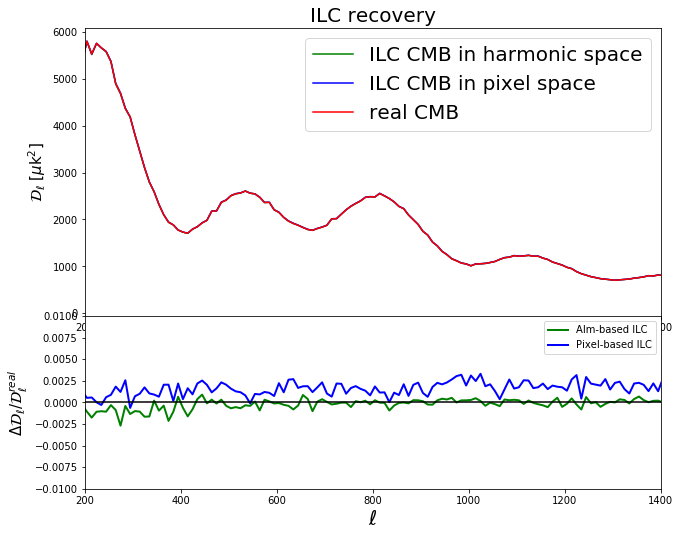

In [21]:
fig1 = plt.figure(1, figsize=(10,8))
plt.axis('off')
frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height
# plt.xlim(2, 200)
s = 2; e = 200
plt.plot(Ell[s:e], Ell[s:e]*(Ell[s:e]+1)/2/np.pi*cl_ilc[s:e], 'g-', label = 'ILC CMB in harmonic space')
plt.plot(Ell, Ell*(Ell+1)/2/np.pi*cls_ILC_pix_bin, 'b-', label = 'ILC CMB in pixel space')
plt.plot(Ell, Ell*(Ell+1)/2/np.pi*cls, 'r-',label = 'real CMB')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*noise_ilc, 'b--', label = 'noise_ilc')
# plt.ylim(2, 6500); 
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_extra, 'b-',label = 'extra CMB')
plt.xlim(200, 1400)

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
# plt.title('ILC in harmonical space, subtracting %s * dust'%frac, fontsize = 20)
plt.title('ILC recovery', fontsize = 20)
# plt.xlim(0, 2000)
frame2=fig1.add_axes((.1,.1,.8,.3))
plt.plot(Ell, (cl_ilc - cls)/cls, 'g-',lw = 2,  label = 'Alm-based ILC') 
plt.plot(Ell, (cls_ILC_pix_bin - cls)/cls, 'b-', lw = 2, label = 'Pixel-based ILC')
plt.legend()
plt.axhline(0,color = 'k')
plt.ylabel(r'$\Delta \mathcal{D}_\ell$/$\mathcal{D}^{real}_{\ell} $ ', fontsize = 15);plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylim(-0.01, 0.01)
plt.xlim(200, 1400)


In [105]:
mask_none = np.arange(hp.nside2npix(nside))
l_deg_max = 100; l_deg_min = 80  
my_mask = (np.radians(l_deg_max) < hp.pix2ang(nside, mask_none)[0] ) + (hp.pix2ang(nside, mask_none)[0] < np.radians(l_deg_min))

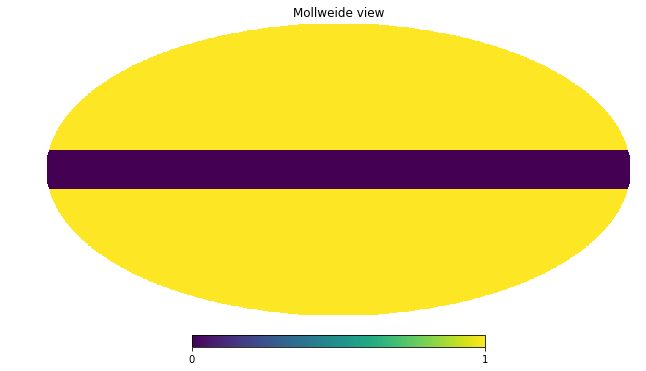

In [106]:
hp.mollview(my_mask)

In [31]:
len(total_I[0][my_mask == True])

10399744

In [32]:
len(total_I[0])

12582912